In [20]:
!git clone https://gitlab-research.centralesupelec.fr/stergios.christodoulidis/text-flappy-bird-gym.git
%cd text-flappy-bird-gym
!pip install -e .


Cloning into 'text-flappy-bird-gym'...
remote: Enumerating objects: 147, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 147 (delta 2), reused 0 (delta 0), pack-reused 141 (from 1)
Receiving objects: 100% (147/147), 556.71 KiB | 522.00 KiB/s, done.
Resolving deltas: 100% (79/79), done.
/content/text-flappy-bird-gym/text-flappy-bird-gym
Obtaining file:///content/text-flappy-bird-gym/text-flappy-bird-gym
  Preparing metadata (setup.py) ... done
  Attempting uninstall: text-flappy-bird-gym
    Found existing installation: text-flappy-bird-gym 0.1.1
    Uninstalling text-flappy-bird-gym-0.1.1:
      Successfully uninstalled text-flappy-bird-gym-0.1.1
  Running setup.py develop for text-flappy-bird-gym


In [ ]:
import gymnasium as gym
import text_flappy_bird_gym
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt

In [21]:


env = gym.make("TextFlappyBird-v0")

obs, _ = env.reset()
done = False
total_reward = 0

while not done:
    action = env.action_space.sample()  # Random action: 0 or 1
    obs, reward, done, truncated, info = env.step(action)
    total_reward += reward
    print(f"Obs: {obs}, Reward: {reward}")

print("Total reward:", total_reward)


Obs: (12, -2), Reward: 1
Obs: (11, -1), Reward: 1
Obs: (10, 2), Reward: 1
Obs: (9, 7), Reward: 1
Total reward: 4


### Monte Carlo Agent

In [24]:

class MonteCarloAgent:
    def __init__(self, epsilon=1.0, gamma=1.0):
        self.Q = defaultdict(lambda: np.zeros(2))
        self.returns_sum = defaultdict(lambda: np.zeros(2))
        self.returns_count = defaultdict(lambda: np.zeros(2))
        self.epsilon = epsilon
        self.gamma = gamma

    def discretize_state(self, state):

        x, y = state
        return (int(x // 1), int(y // 1))

    def policy(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.choice(2)
        return np.argmax(self.Q[state])

    def generate_episode(self, env):
        obs, _ = env.reset()
        episode = []
        state = self.discretize_state(obs)
        done = False
        while not done:
            action = self.policy(state)
            obs, reward, done, _, _ = env.step(action)
            episode.append((state, action, reward))
            state = self.discretize_state(obs)
        return episode

    def update(self, episode):
        G = 0
        visited = set()
        for t in reversed(range(len(episode))):
            state, action, reward = episode[t]
            G = self.gamma * G + reward
            if (state, action) not in visited:
                visited.add((state, action))
                self.returns_sum[state][action] += G
                self.returns_count[state][action] += 1
                self.Q[state][action] = self.returns_sum[state][action] / self.returns_count[state][action]

    def train(self, env, episodes=5000):
        rewards = []
        for i in range(episodes):
            self.epsilon = max(0.01, self.epsilon * 0.999)  # ε decay
            episode = self.generate_episode(env)
            self.update(episode)
            total_reward = sum([r for (_, _, r) in episode])
            rewards.append(total_reward)
            if i % 500 == 0:
                print(f"Episode {i}, Total reward: {total_reward}, ε = {self.epsilon:.3f}")
        return rewards


In [26]:
env = gym.make("TextFlappyBird-v0")
agent = MonteCarloAgent(epsilon=1.0, gamma=1.0)
reward_history = agent.train(env, episodes=50000)


Episode 0, Total reward: 4, ε = 0.999
Episode 500, Total reward: 34, ε = 0.606
Episode 1000, Total reward: 13, ε = 0.367
Episode 1500, Total reward: 13, ε = 0.223
Episode 2000, Total reward: 18, ε = 0.135
Episode 2500, Total reward: 53, ε = 0.082
Episode 3000, Total reward: 23, ε = 0.050
Episode 3500, Total reward: 248, ε = 0.030
Episode 4000, Total reward: 696, ε = 0.018
Episode 4500, Total reward: 20, ε = 0.011
Episode 5000, Total reward: 24, ε = 0.010
Episode 5500, Total reward: 147, ε = 0.010
Episode 6000, Total reward: 54, ε = 0.010
Episode 6500, Total reward: 24, ε = 0.010
Episode 7000, Total reward: 312, ε = 0.010
Episode 7500, Total reward: 23, ε = 0.010
Episode 8000, Total reward: 136, ε = 0.010
Episode 8500, Total reward: 84, ε = 0.010
Episode 9000, Total reward: 173, ε = 0.010
Episode 9500, Total reward: 145, ε = 0.010
Episode 10000, Total reward: 268, ε = 0.010
Episode 10500, Total reward: 83, ε = 0.010
Episode 11000, Total reward: 44, ε = 0.010
Episode 11500, Total reward:

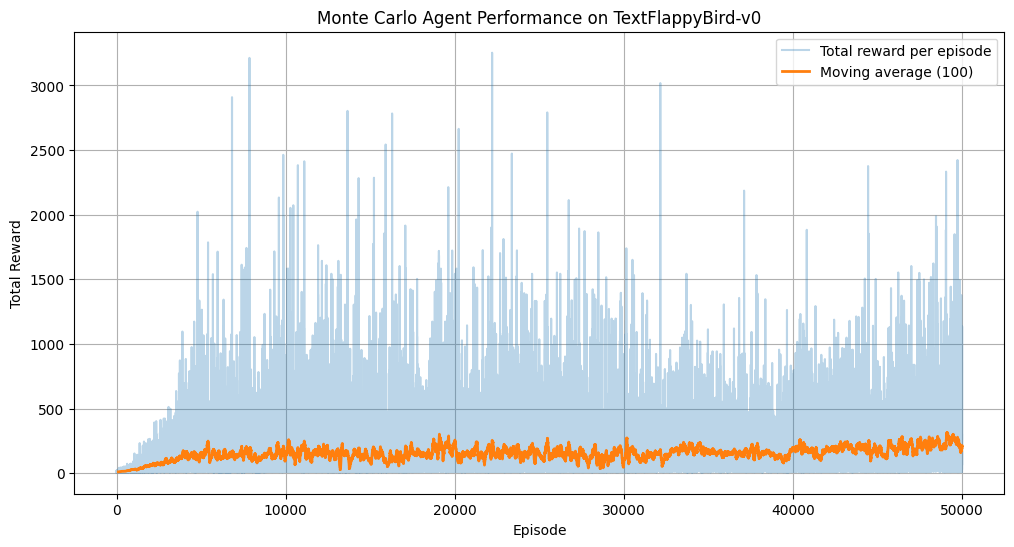

In [28]:


def plot_rewards(reward_history, window=100):
    plt.figure(figsize=(12, 6))
    plt.plot(reward_history, label="Total reward per episode", alpha=0.3)

    # Moving average
    if len(reward_history) >= window:
        moving_avg = np.convolve(reward_history, np.ones(window)/window, mode='valid')
        plt.plot(range(window - 1, len(reward_history)), moving_avg, label=f"Moving average ({window})", linewidth=2)

    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.title("Monte Carlo Agent Performance on TextFlappyBird-v0")
    plt.legend()
    plt.grid()
    plt.show()

# Plot the results
plot_rewards(reward_history)


### Sarsa Lambda Agent

In [29]:

class SarsaLambdaAgent:
    def __init__(self, alpha=0.1, gamma=0.99, epsilon=1.0, lam=0.9):
        self.Q = defaultdict(lambda: np.zeros(2))
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.lam = lam

    def discretize_state(self, state):
        x, y = state
        return (int(x // 1), int(y // 1))  #

    def policy(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.choice(2)
        return np.argmax(self.Q[state])

    def train(self, env, episodes=5000):
        rewards = []
        for ep in range(episodes):
            self.epsilon = max(0.01, self.epsilon * 0.999)
            obs, _ = env.reset()
            state = self.discretize_state(obs)
            action = self.policy(state)
            eligibility = defaultdict(lambda: np.zeros(2))
            done = False
            total_reward = 0

            while not done:
                next_obs, reward, done, _, _ = env.step(action)
                next_state = self.discretize_state(next_obs)
                next_action = self.policy(next_state)

                delta = reward + self.gamma * self.Q[next_state][next_action] - self.Q[state][action]
                eligibility[state][action] += 1

                for s in self.Q.keys():
                    for a in [0, 1]:
                        self.Q[s][a] += self.alpha * delta * eligibility[s][a]
                        eligibility[s][a] *= self.gamma * self.lam

                state = next_state
                action = next_action
                total_reward += reward

            rewards.append(total_reward)
            if ep % 500 == 0:
                print(f"Episode {ep}, Total reward: {total_reward}, ε = {self.epsilon:.3f}")
        return rewards


Episode 0, Total reward: 29, ε = 0.999
Episode 500, Total reward: 33, ε = 0.606
Episode 1000, Total reward: 53, ε = 0.367
Episode 1500, Total reward: 33, ε = 0.223
Episode 2000, Total reward: 128, ε = 0.135
Episode 2500, Total reward: 463, ε = 0.082
Episode 3000, Total reward: 8, ε = 0.050
Episode 3500, Total reward: 118, ε = 0.030
Episode 4000, Total reward: 46, ε = 0.018
Episode 4500, Total reward: 38, ε = 0.011


In [30]:
def evaluate_lambda_values(env, lambda_values, episodes=2000):
    results = {}
    for lam in lambda_values:
        print(f"\nTraining with λ = {lam}")
        agent = SarsaLambdaAgent(alpha=0.1, gamma=0.99, epsilon=1.0, lam=lam)
        rewards = agent.train(env, episodes=episodes)
        results[lam] = rewards
    return results


In [31]:
env = gym.make("TextFlappyBird-v0")
lambda_values = [0.0, 0.4, 0.7, 0.9, 0.95, 1.0]
sweep_results = evaluate_lambda_values(env, lambda_values, episodes=5000)



Training with λ = 0.0
Episode 0, Total reward: 13, ε = 0.999
Episode 500, Total reward: 6, ε = 0.606
Episode 1000, Total reward: 23, ε = 0.367
Episode 1500, Total reward: 23, ε = 0.223
Episode 2000, Total reward: 101, ε = 0.135
Episode 2500, Total reward: 18, ε = 0.082
Episode 3000, Total reward: 147, ε = 0.050
Episode 3500, Total reward: 117, ε = 0.030
Episode 4000, Total reward: 1047, ε = 0.018
Episode 4500, Total reward: 16, ε = 0.011

Training with λ = 0.4
Episode 0, Total reward: 7, ε = 0.999
Episode 500, Total reward: 22, ε = 0.606
Episode 1000, Total reward: 6, ε = 0.367
Episode 1500, Total reward: 11, ε = 0.223
Episode 2000, Total reward: 27, ε = 0.135
Episode 2500, Total reward: 213, ε = 0.082
Episode 3000, Total reward: 283, ε = 0.050
Episode 3500, Total reward: 793, ε = 0.030
Episode 4000, Total reward: 143, ε = 0.018
Episode 4500, Total reward: 738, ε = 0.011

Training with λ = 0.7
Episode 0, Total reward: 4, ε = 0.999
Episode 500, Total reward: 23, ε = 0.606
Episode 1000,

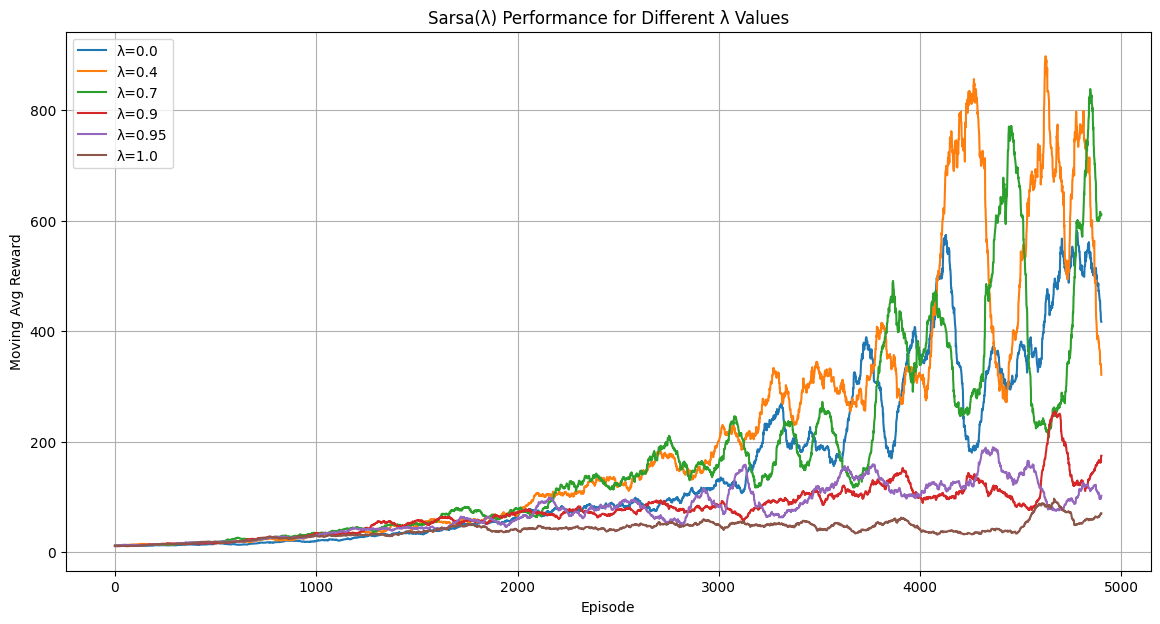

In [32]:


def plot_lambda_sweep(sweep_results, window=100):
    plt.figure(figsize=(14, 7))
    for lam, rewards in sweep_results.items():
        if len(rewards) >= window:
            moving_avg = np.convolve(rewards, np.ones(window)/window, mode='valid')
            plt.plot(moving_avg, label=f"λ={lam}")
    plt.title("Sarsa(λ) Performance for Different λ Values")
    plt.xlabel("Episode")
    plt.ylabel("Moving Avg Reward")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_lambda_sweep(sweep_results)


In [33]:
env = gym.make("TextFlappyBird-v0")
agent = SarsaLambdaAgent(alpha=0.1, gamma=0.99, epsilon=1.0, lam=0.4)
sarsa_rewards = agent.train(env, episodes=20000)

Episode 0, Total reward: 13, ε = 0.999
Episode 500, Total reward: 13, ε = 0.606
Episode 1000, Total reward: 13, ε = 0.367
Episode 1500, Total reward: 162, ε = 0.223
Episode 2000, Total reward: 13, ε = 0.135
Episode 2500, Total reward: 233, ε = 0.082
Episode 3000, Total reward: 302, ε = 0.050
Episode 3500, Total reward: 243, ε = 0.030
Episode 4000, Total reward: 1053, ε = 0.018
Episode 4500, Total reward: 203, ε = 0.011
Episode 5000, Total reward: 1313, ε = 0.010
Episode 5500, Total reward: 73, ε = 0.010
Episode 6000, Total reward: 703, ε = 0.010
Episode 6500, Total reward: 28, ε = 0.010
Episode 7000, Total reward: 197, ε = 0.010
Episode 7500, Total reward: 663, ε = 0.010
Episode 8000, Total reward: 86, ε = 0.010
Episode 8500, Total reward: 2963, ε = 0.010
Episode 9000, Total reward: 208, ε = 0.010
Episode 9500, Total reward: 87, ε = 0.010
Episode 10000, Total reward: 118, ε = 0.010
Episode 10500, Total reward: 178, ε = 0.010
Episode 11000, Total reward: 678, ε = 0.010
Episode 11500, To

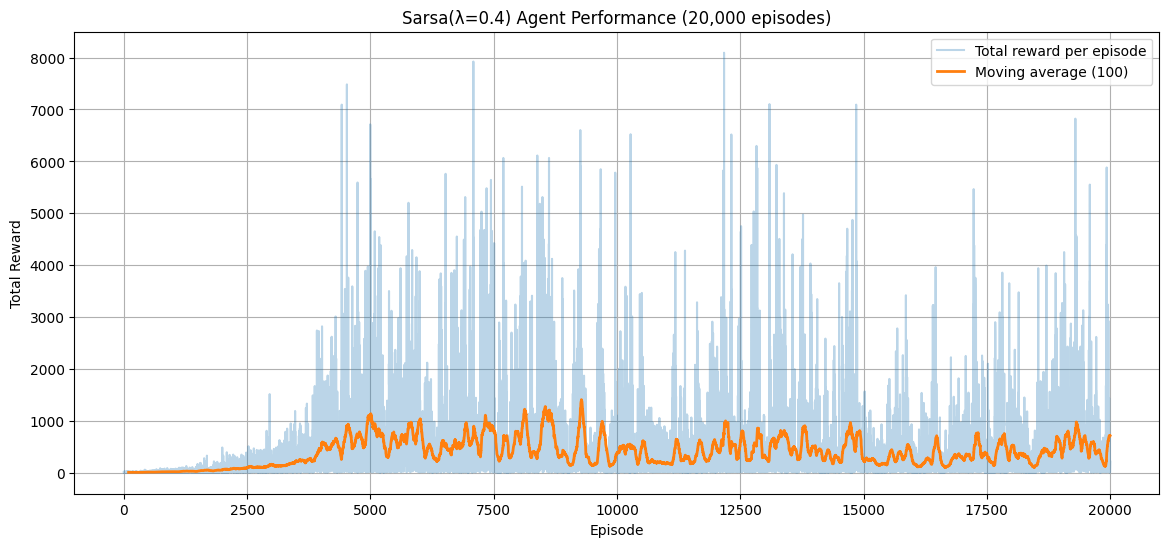

In [34]:
def plot_rewards(rewards, window=100):
    plt.figure(figsize=(14, 6))
    plt.plot(rewards, label='Total reward per episode', alpha=0.3)
    if len(rewards) >= window:
        moving_avg = np.convolve(rewards, np.ones(window)/window, mode='valid')
        plt.plot(range(window - 1, len(rewards)), moving_avg, label=f"Moving average ({window})", linewidth=2)

    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.title("Sarsa(λ=0.4) Agent Performance (20,000 episodes)")
    plt.legend()
    plt.grid(True)

    plt.show()

# Save and display
plot_rewards(sarsa_rewards, window=100)


### Comparaison between the two agents

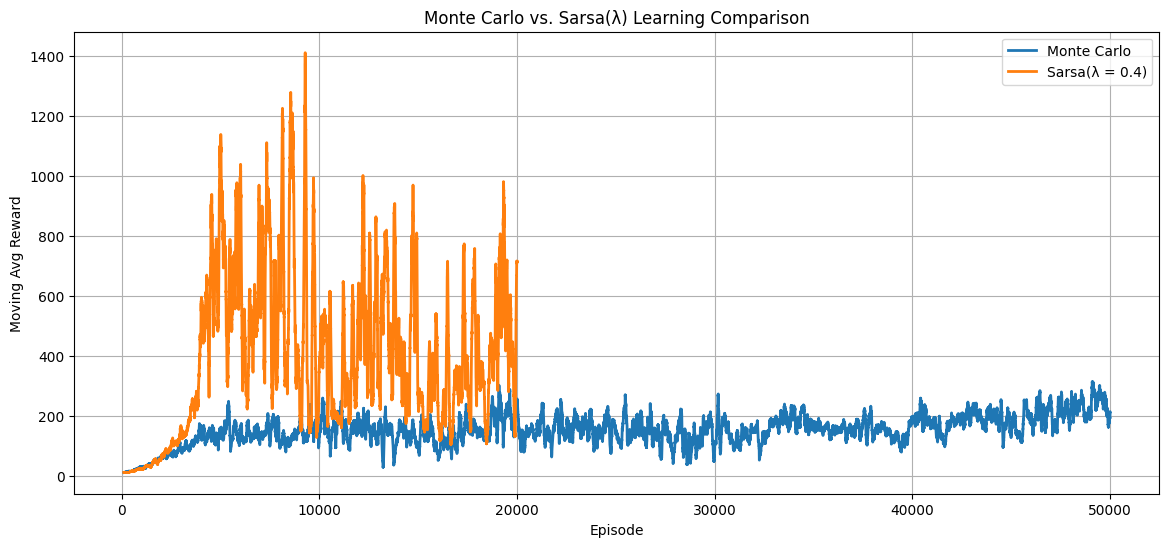

In [35]:
def plot_comparison(mc_rewards, sarsa_rewards, window=100):
    plt.figure(figsize=(14, 6))

    # Monte Carlo
    mc_avg = np.convolve(mc_rewards, np.ones(window)/window, mode='valid')
    plt.plot(range(window - 1, len(mc_rewards)), mc_avg, label="Monte Carlo", linewidth=2)

    # Sarsa(λ)
    sarsa_avg = np.convolve(sarsa_rewards, np.ones(window)/window, mode='valid')
    plt.plot(range(window - 1, len(sarsa_rewards)), sarsa_avg, label="Sarsa(λ = 0.4)", linewidth=2)

    plt.xlabel("Episode")
    plt.ylabel("Moving Avg Reward")
    plt.title("Monte Carlo vs. Sarsa(λ) Learning Comparison")
    plt.legend()
    plt.grid(True)


    plt.show()


plot_comparison(reward_history, sarsa_rewards, window=100)
